# Loading libraries

In [478]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandasql import sqldf
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
from itertools import combinations
import scipy.stats
import statistics

con = sqlite3.Connection('Northwind_small.sqlite')
cur = con.cursor()

# Loading tables

In [344]:
cur.execute("""Select name
               From sqlite_master 
               Where type="table";""")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [345]:
cur.execute("""Select * 
               From OrderDetail
;""")
OrderDetail_df = pd.DataFrame(cur.fetchall())
OrderDetail_df.columns = [x[0] for x in cur.description]

In [346]:
OrderDetail_df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [266]:
cur.execute("""Select Discount, Avg(Quantity)
               From OrderDetail
               Group by 1
;""")
discount_avgquant_df = pd.DataFrame(cur.fetchall())
discount_avgquant_df.columns = [x[0] for x in cur.description]
discount_avgquant_df

,Discount,Avg(Quantity)
0,0.00,21.715262
1,0.01,2.000000
2,0.02,2.000000
3,0.03,1.666667
4,0.04,1.000000
5,0.05,28.010811
6,0.06,2.000000
7,0.10,25.236994
8,0.15,28.382166
9,0.20,27.024845


In [267]:
cur.execute("""Select ProductId, Avg(Quantity)
               From OrderDetail
               Where Discount = 0.00
               Group by 1
;""")
quantity_nodiscount_df = pd.DataFrame(cur.fetchall())
quantity_nodiscount_df.columns = [x[0] for x in cur.description]

In [268]:
quantity_nodiscount_df

,ProductId,Avg(Quantity)
0,1,17.772727
1,2,21.473684
2,3,28.800000
3,4,17.200000
4,5,29.333333
...,...,...
72,73,22.125000
73,74,22.600000
74,75,21.758621
75,76,22.730769


In [269]:
cur.execute("""Select ProductId, Avg(Quantity)
               From OrderDetail
               Where Discount != 0.00
               Group by 1
;""")
quantity_discount_df = pd.DataFrame(cur.fetchall())
quantity_discount_df.columns = [x[0] for x in cur.description]

In [270]:
quantity_discount_df

,ProductId,Avg(Quantity)
0,1,27.312500
1,2,25.960000
2,3,20.000000
3,4,28.100000
4,5,30.500000
...,...,...
72,73,19.333333
73,74,23.666667
74,75,30.823529
75,76,30.000000


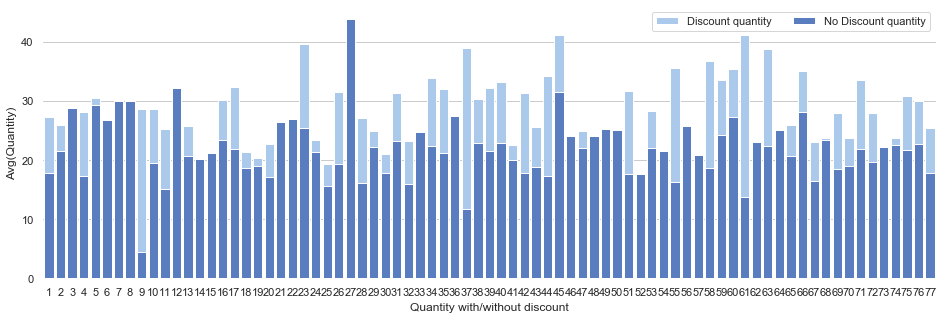

In [271]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes("pastel")
sns.barplot(x="ProductId", y="Avg(Quantity)", data=quantity_discount_df,
            label="Discount quantity", color="b")
sns.set_color_codes("muted")
sns.barplot(x="ProductId", y="Avg(Quantity)", data=quantity_nodiscount_df,
            label="No Discount quantity", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlabel="Quantity with/without discount")
sns.despine(left=True, bottom=True)

## Cohen_d

In [481]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return abs(d)

## Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- H0:there is no difference in order quantity due to discount
- H1:there is difference in order quantity due to discount

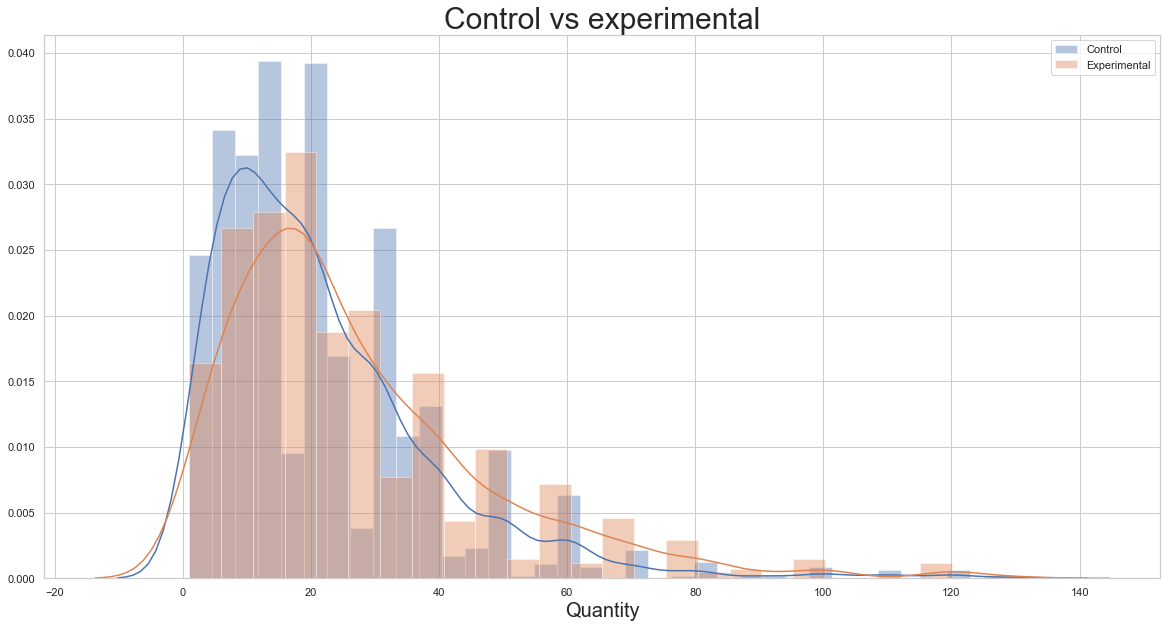

In [448]:
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']
plt.figure(figsize=(20, 10))
sns.distplot(control, label='Control')
sns.set_color_codes("muted")
sns.distplot(experimental, label='Experimental' )
plt.title('Control vs experimental',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

## Normalize the data

In [449]:
scipy.stats.normaltest(control)

NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)

In [450]:
scipy.stats.normaltest(experimental)

NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)

In [468]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x) 
    return sample
def get_sample_mean(sample):
    return sum(sample) / len(sample)
def create_sample_distribution(data, dist_size=1000, n=50):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

In [469]:
control_sample = create_sample_distribution(control)

In [487]:
len(control_sample)

1000

In [471]:
experimental_sample = create_sample_distribution(experimental)

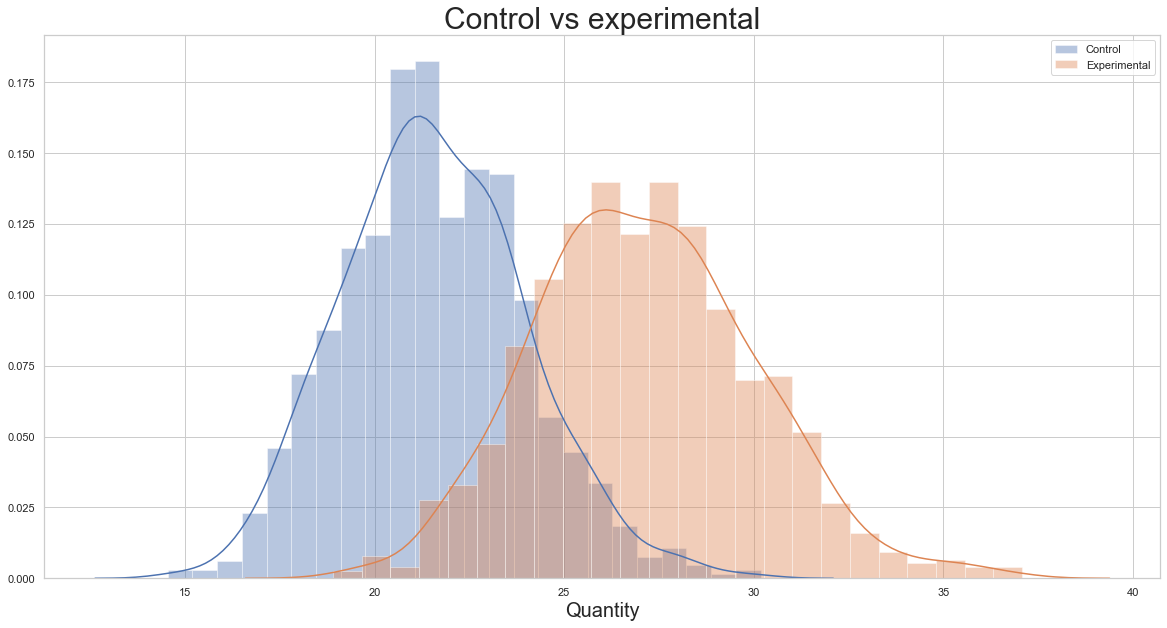

In [472]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample, label='Control')
sns.set_color_codes("muted")
sns.distplot(experimental_sample, label='Experimental' )
plt.title('Control vs experimental',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

## Calculate the Cohen'd and p value

In [482]:
p = stats.ttest_ind(control_sample, experimental_sample)[1]
d = Cohen_d(np.array(control_sample), np.array(experimental_sample))

In [489]:
print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 5.34e-322 effect size is 2.0873533965359647
It has a large effect
Reject Null Hypothesis


## ANOVA

In [494]:
discount_list = [0,0.05,0.1,0.15,0.2,0.25]
combos = combinations(discount_list, 2)
# list(combos)

for combo in list(combos):
    discount1 = combo[0]
    discount2 = combo[1]
    sample1 = OrderDetail_df[OrderDetail_df['Discount']==discount1]['Quantity']
    sample2 = OrderDetail_df[OrderDetail_df['Discount']==discount2]['Quantity']
    p = stats.ttest_ind(sample1, sample2, equal_var=False)[1]
    d = Cohen_d(np.array(sample1), np.array(sample2))
    print(combo, 'p value is', p)
    print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
# list(combos)

(0, 0.05) p value is 0.00027233494432847593
Reject Null Hypothesis
(0, 0.1) p value is 0.0374559661063408
Failed to reject Null Hypothesis
(0, 0.15) p value is 0.00017220729443627393
Reject Null Hypothesis
(0, 0.2) p value is 0.0008110033254043408
Reject Null Hypothesis
(0, 0.25) p value is 0.00015923050922125637
Reject Null Hypothesis
(0.05, 0.1) p value is 0.22710466225198522
Failed to reject Null Hypothesis
(0.05, 0.15) p value is 0.873701937770792
Failed to reject Null Hypothesis
(0.05, 0.2) p value is 0.6551134299813659
Failed to reject Null Hypothesis
(0.05, 0.25) p value is 0.9205932482537716
Failed to reject Null Hypothesis
(0.1, 0.15) p value is 0.17616507980479174
Failed to reject Null Hypothesis
(0.1, 0.2) p value is 0.414945941918507
Failed to reject Null Hypothesis
(0.1, 0.25) p value is 0.1897558400462687
Failed to reject Null Hypothesis
(0.15, 0.2) p value is 0.5439367225420654
Failed to reject Null Hypothesis
(0.15, 0.25) p value is 0.9514228832450177
Failed to reject N

### 5%, 15%, 20%, 25% is most effetive discounts the shop should take

## Q2: did sales performance same in the first quarter of 2014 compared with same period of 2013? any improvement or decline

In [358]:
cur.execute("""Select * 
               From [Order]
;""")
Order_df = pd.DataFrame(cur.fetchall())
Order_df.columns = [x[0] for x in cur.description]

In [359]:
Order_df

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico
826,11074,SIMOB,7,2014-05-06,2014-06-03,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
827,11075,RICSU,8,2014-05-06,2014-06-03,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
828,11076,BONAP,4,2014-05-06,2014-06-03,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,Western Europe,13008,France


In [355]:
Order_df.OrderDate

0      2012-07-04
1      2012-07-05
2      2012-07-08
3      2012-07-08
4      2012-07-09
          ...    
825    2014-05-05
826    2014-05-06
827    2014-05-06
828    2014-05-06
829    2014-05-06
Name: OrderDate, Length: 830, dtype: object

In [360]:
Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)

In [361]:
Order_df.OrderDate

0     2012-07-04
1     2012-07-05
2     2012-07-08
3     2012-07-08
4     2012-07-09
         ...    
825   2014-05-05
826   2014-05-06
827   2014-05-06
828   2014-05-06
829   2014-05-06
Name: OrderDate, Length: 830, dtype: datetime64[ns]

Because we only have data covering less than two years, therefore we will compare 2013.01.01 - 2013.05.01 with 2014.01.01 - 2014.05.01 Both cover the first 4 months time. 

In [350]:
len(Order_df)

830

In [438]:
cur.execute("""Select OrderDate,
                      Quantity as '2013-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-01-01' And
                     OrderDate <= '2013-05-01'
               ;""")
Order_date_ctrl_df = pd.DataFrame(cur.fetchall())
Order_date_ctrl_df.columns = [x[0] for x in cur.description]

In [439]:
Order_date_ctrl_df

,OrderDate,2013-1q
0,2013-01-01,21
1,2013-01-01,35
2,2013-01-01,30
3,2013-01-01,18
4,2013-01-01,70
...,...,...
325,2013-05-01,6
326,2013-05-01,2
327,2013-05-01,10
328,2013-05-01,60


In [557]:
cur.execute("""Select OrderDate,
                      Avg(Quantity) as 'Avg-daily-sales'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-01-01' And
                     OrderDate <= '2013-05-01'
               Group by 1
               ;""")
Order_dateavg_ctrl_df = pd.DataFrame(cur.fetchall())
Order_dateavg_ctrl_df.columns = [x[0] for x in cur.description]

In [558]:
Order_dateavg_ctrl_df['OrderDate'] = pd.to_datetime(Order_dateavg_ctrl_df['OrderDate'])

In [559]:
Order_dateavg_ctrl_df['OrderDate']

0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-06
4    2013-01-07
        ...    
82   2013-04-25
83   2013-04-28
84   2013-04-29
85   2013-04-30
86   2013-05-01
Name: OrderDate, Length: 87, dtype: datetime64[ns]

In [528]:
def getMonthDay(s):
    return str(s).split("-")[1]+"-"+str(s).split("-")[2]

In [529]:
Order_dateavg_ctrl_df['month-day']= Order_dateavg_ctrl_df['OrderDate'].apply(lambda x: getMonthDay(x))

In [530]:
Order_dateavg_ctrl_df

,OrderDate,Avg-daily-sales,month-day
0,2013-01-01,36.285714,01-01
1,2013-01-02,62.500000,01-02
2,2013-01-03,38.200000,01-03
3,2013-01-06,50.000000,01-06
4,2013-01-07,18.625000,01-07
...,...,...,...
82,2013-04-25,9.666667,04-25
83,2013-04-28,22.000000,04-28
84,2013-04-29,6.400000,04-29
85,2013-04-30,27.250000,04-30


In [565]:
cur.execute("""Select OrderDate,
                      Quantity as '2014-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-01-01' And
                     OrderDate <= '2014-05-01'
               ;""")
Order_date_exp_df = pd.DataFrame(cur.fetchall())
Order_date_exp_df.columns = [x[0] for x in cur.description]

In [566]:
Order_date_exp_df

,OrderDate,2014-1q
0,2014-01-01,20
1,2014-01-01,50
2,2014-01-01,20
3,2014-01-01,7
4,2014-01-01,5
...,...,...
637,2014-05-01,4
638,2014-05-01,20
639,2014-05-01,3
640,2014-05-01,42


In [563]:
cur.execute("""Select OrderDate,
                      Avg(Quantity) as 'Avg-daily-sales'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-01-01' And
                     OrderDate <= '2014-05-01'
               Group by 1
               ;""")
Order_dateavg_exp_df = pd.DataFrame(cur.fetchall())
Order_dateavg_exp_df.columns = [x[0] for x in cur.description]

In [564]:
Order_dateavg_exp_df

,OrderDate,Avg-daily-sales
0,2014-01-01,17.833333
1,2014-01-02,23.166667
2,2014-01-05,20.142857
3,2014-01-06,34.166667
4,2014-01-07,19.400000
...,...,...
82,2014-04-27,25.714286
83,2014-04-28,25.000000
84,2014-04-29,15.428571
85,2014-04-30,18.875000


In [526]:
Order_dateavg_exp_df['month-day']= Order_dateavg_exp_df['OrderDate'].apply(lambda x: getMonthDay(x))

In [527]:
Order_dateavg_exp_df

,OrderDate,Avg-daily-sales,month-day
0,2014-01-01,17.833333,01-01
1,2014-01-02,23.166667,01-02
2,2014-01-05,20.142857,01-05
3,2014-01-06,34.166667,01-06
4,2014-01-07,19.400000,01-07
...,...,...,...
82,2014-04-27,25.714286,04-27
83,2014-04-28,25.000000,04-28
84,2014-04-29,15.428571,04-29
85,2014-04-30,18.875000,04-30


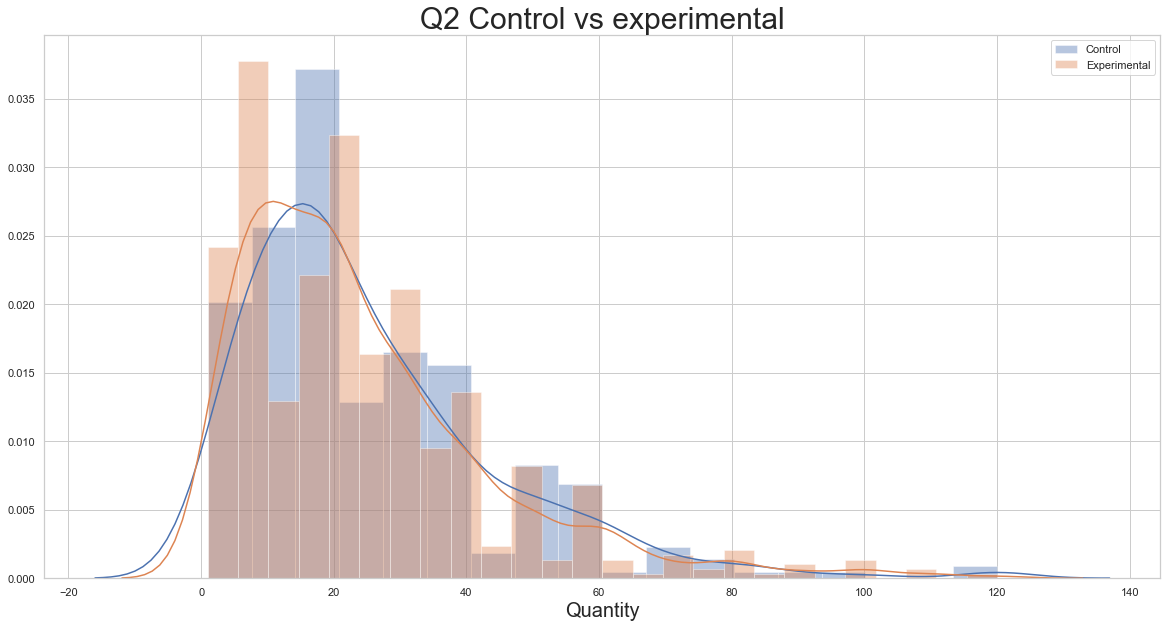

In [416]:
ctrl_q2 = Order_date_ctrl_df['2013-1q']
exp_q2 = Order_date_exp_df['2014-1q']
plt.figure(figsize=(20, 10))
sns.distplot(ctrl_q2, label='Control')
sns.distplot(exp_q2, label='Experimental' )
plt.title('Q2 Control vs experimental',fontsize=30)
plt.xlabel('Quantity', fontsize=20)
plt.legend();

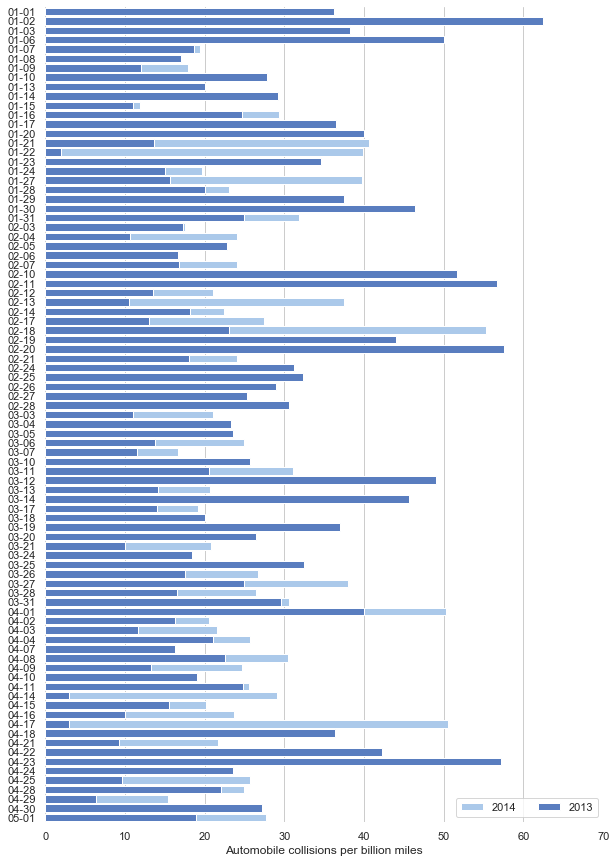

In [536]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Avg-daily-sales", y="month-day", data=Order_dateavg_exp_df,
            label="2014", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Avg-daily-sales", y="month-day", data=Order_dateavg_ctrl_df,
            label="2013", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 70), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [537]:
scipy.stats.normaltest(ctrl_q2)

NormaltestResult(statistic=114.93293200402849, pvalue=1.103140732547098e-25)

In [538]:
scipy.stats.normaltest(exp_q2)

NormaltestResult(statistic=211.32053625577106, pvalue=1.2951754257032017e-46)

In [542]:
control_sample_q2 = create_sample_distribution(ctrl_q2)

In [543]:
experiment_sample_q2 = create_sample_distribution(exp_q2)

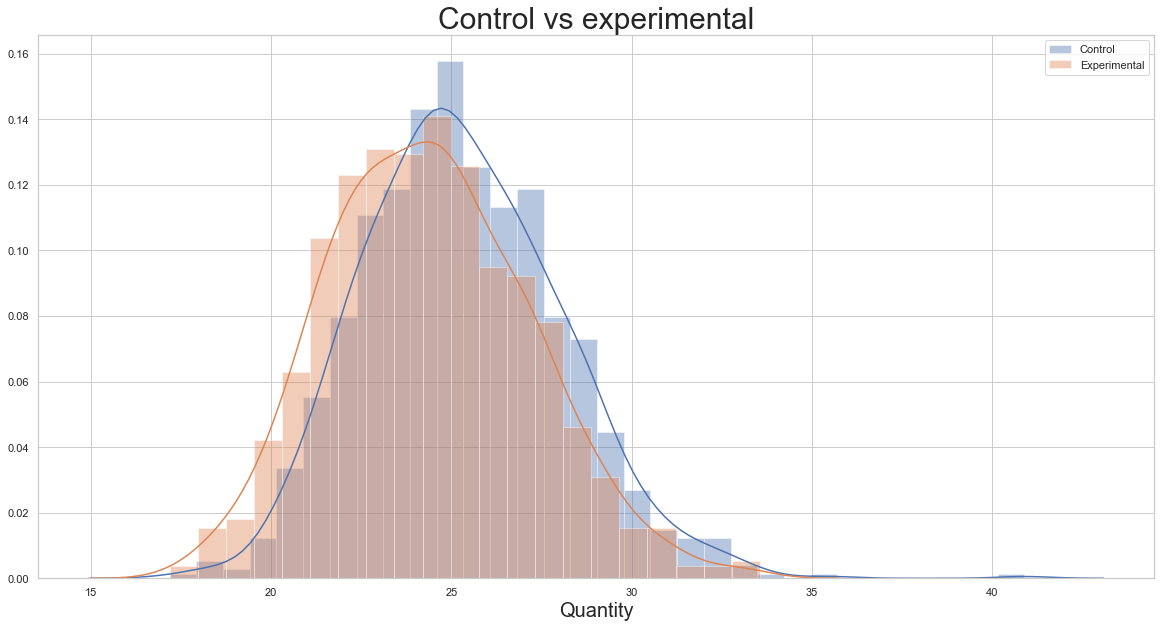

In [545]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample_q2, label='Control')
sns.set_color_codes("muted")
sns.distplot(experiment_sample_q2, label='Experimental' )
plt.title('Control vs experimental',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

In [546]:
p = stats.ttest_ind(control_sample_q2, experiment_sample_q2)[1]
d = Cohen_d(np.array(control_sample_q2), np.array(experiment_sample_q2))

In [547]:
print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 7.355292179816556e-14 effect size is 0.3371451118845863
It has a small effect
Reject Null Hypothesis


## Check each month to see the improvement

## Janurary

In [579]:
Order_date_1q_df = []
cur.execute("""Select OrderDate,
                      Quantity as '2013-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-01-01' And
                     OrderDate < '2013-02-01'
               ;""")
Order_date_ctrl_jan_df = pd.DataFrame(cur.fetchall())
Order_date_ctrl_jan_df.columns = [x[0] for x in cur.description]

In [623]:
Order_date_ctrl_jan_df

,OrderDate,2013-1q
0,2013-01-01,21
1,2013-01-01,35
2,2013-01-01,30
3,2013-01-01,18
4,2013-01-01,70
...,...,...
80,2013-01-30,50
81,2013-01-30,50
82,2013-01-30,30
83,2013-01-31,10


In [576]:
cur.execute("""Select OrderDate,
                      Quantity as '2014-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-01-01' And
                     OrderDate < '2014-02-01'
               ;""")
Order_date_exp_jan_df = pd.DataFrame(cur.fetchall())
Order_date_exp_jan_df.columns = [x[0] for x in cur.description]

In [624]:
Order_date_exp_jan_df

,OrderDate,2014-1q
0,2014-01-01,20
1,2014-01-01,50
2,2014-01-01,20
3,2014-01-01,7
4,2014-01-01,5
...,...,...
147,2014-01-30,40
148,2014-01-30,35
149,2014-01-30,3
150,2014-01-30,25


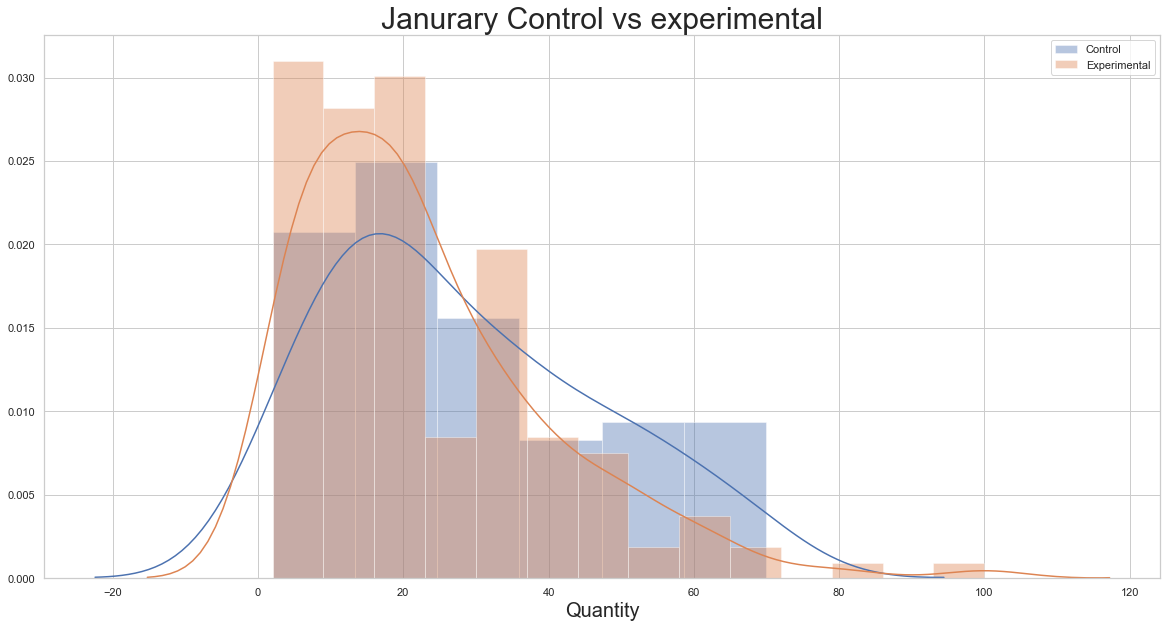

In [583]:
ctrl_q2_jan = Order_date_ctrl_jan_df['2013-1q']
exp_q2_jan = Order_date_exp_jan_df['2014-1q']
plt.figure(figsize=(20, 10))
sns.distplot(ctrl_q2_jan, label='Control')
sns.distplot(exp_q2_jan, label='Experimental' )
plt.title('Janurary Control vs experimental',fontsize=30)
plt.xlabel('Quantity', fontsize=20)
plt.legend();

In [584]:
scipy.stats.normaltest(ctrl_q2_jan)

NormaltestResult(statistic=7.0879465081341335, pvalue=0.028898278472400552)

In [585]:
scipy.stats.normaltest(exp_q2_jan)

NormaltestResult(statistic=44.43530382977988, pvalue=2.2438631816344396e-10)

In [587]:
control_sample_jan_q2 = create_sample_distribution(ctrl_q2_jan)
experiment_sample_jan_q2 = create_sample_distribution(exp_q2_jan)

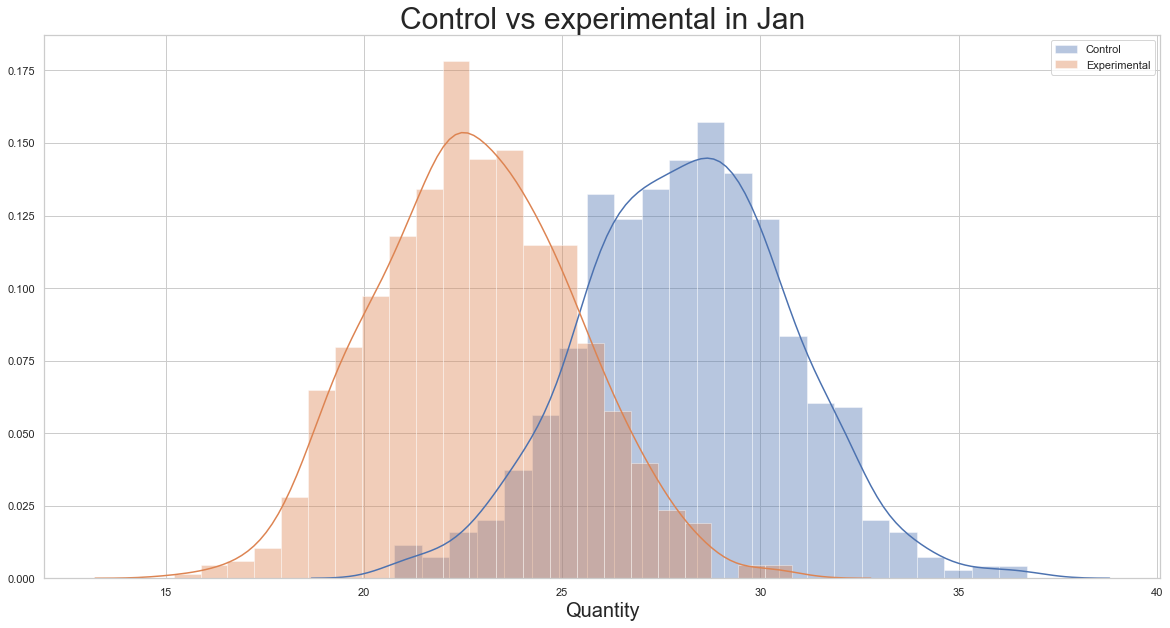

In [588]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample_jan_q2, label='Control')
sns.set_color_codes("muted")
sns.distplot(experiment_sample_jan_q2, label='Experimental' )
plt.title('Control vs experimental in Jan',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

In [589]:
p = stats.ttest_ind(control_sample_jan_q2, experiment_sample_jan_q2)[1]
d = Cohen_d(np.array(control_sample_jan_q2), np.array(experiment_sample_jan_q2))

In [590]:
print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 1.374e-321 effect size is 2.0854262086706803
It has a large effect
Reject Null Hypothesis


## Feb

In [591]:
cur.execute("""Select OrderDate,
                      Quantity as '2013-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-02-01' And
                     OrderDate < '2013-03-01'
               ;""")
Order_date_ctrl_feb_df = pd.DataFrame(cur.fetchall())
Order_date_ctrl_feb_df.columns = [x[0] for x in cur.description]

In [592]:
cur.execute("""Select OrderDate,
                      Quantity as '2014-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-02-01' And
                     OrderDate < '2014-03-01'
               ;""")
Order_date_exp_feb_df = pd.DataFrame(cur.fetchall())
Order_date_exp_feb_df.columns = [x[0] for x in cur.description]

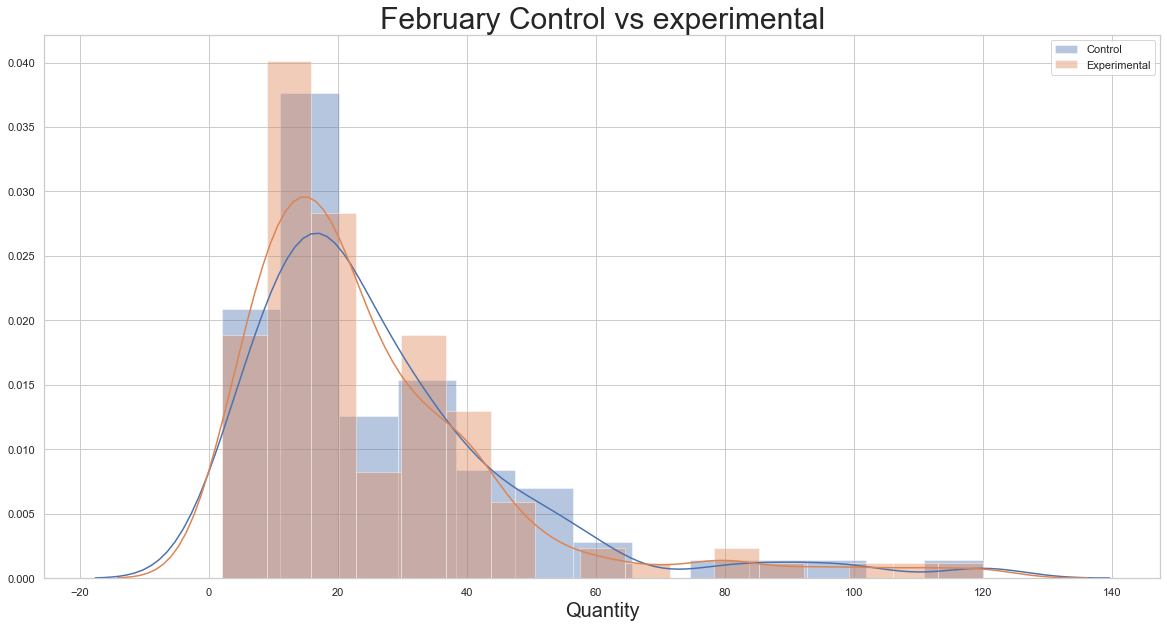

In [593]:
ctrl_q2_feb = Order_date_ctrl_feb_df['2013-1q']
exp_q2_feb = Order_date_exp_feb_df['2014-1q']
plt.figure(figsize=(20, 10))
sns.distplot(ctrl_q2_feb, label='Control')
sns.distplot(exp_q2_feb, label='Experimental' )
plt.title('February Control vs experimental',fontsize=30)
plt.xlabel('Quantity', fontsize=20)
plt.legend();

In [594]:
scipy.stats.normaltest(ctrl_q2_feb)

NormaltestResult(statistic=45.954803054503806, pvalue=1.0496422614003084e-10)

In [595]:
scipy.stats.normaltest(exp_q2_feb)

NormaltestResult(statistic=67.85705900332815, pvalue=1.840885844962387e-15)

In [596]:
control_sample_feb_q2 = create_sample_distribution(ctrl_q2_feb)
experiment_sample_feb_q2 = create_sample_distribution(exp_q2_feb)

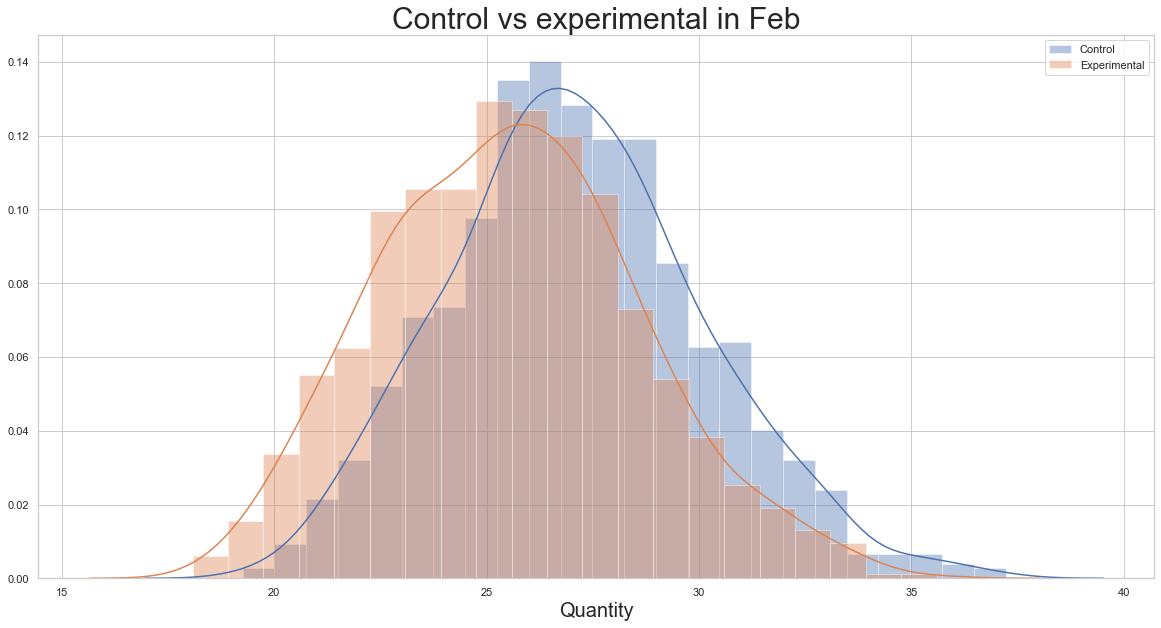

In [597]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample_feb_q2, label='Control')
sns.set_color_codes("muted")
sns.distplot(experiment_sample_feb_q2, label='Experimental' )
plt.title('Control vs experimental in Feb',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

In [598]:
p = stats.ttest_ind(control_sample_feb_q2, experiment_sample_feb_q2)[1]
d = Cohen_d(np.array(control_sample_feb_q2), np.array(experiment_sample_feb_q2))

In [599]:
 print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 1.12745756892122e-28 effect size is 0.5049231316091919
It has a medium effect
Reject Null Hypothesis


## Mar

In [600]:
cur.execute("""Select OrderDate,
                      Quantity as '2013-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-03-01' And
                     OrderDate < '2013-04-01'
               ;""")
Order_date_ctrl_mar_df = pd.DataFrame(cur.fetchall())
Order_date_ctrl_mar_df.columns = [x[0] for x in cur.description]

In [603]:
cur.execute("""Select OrderDate,
                      Quantity as '2014-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-03-01' And
                     OrderDate < '2014-04-01'
               ;""")
Order_date_exp_mar_df = pd.DataFrame(cur.fetchall())
Order_date_exp_mar_df.columns = [x[0] for x in cur.description]

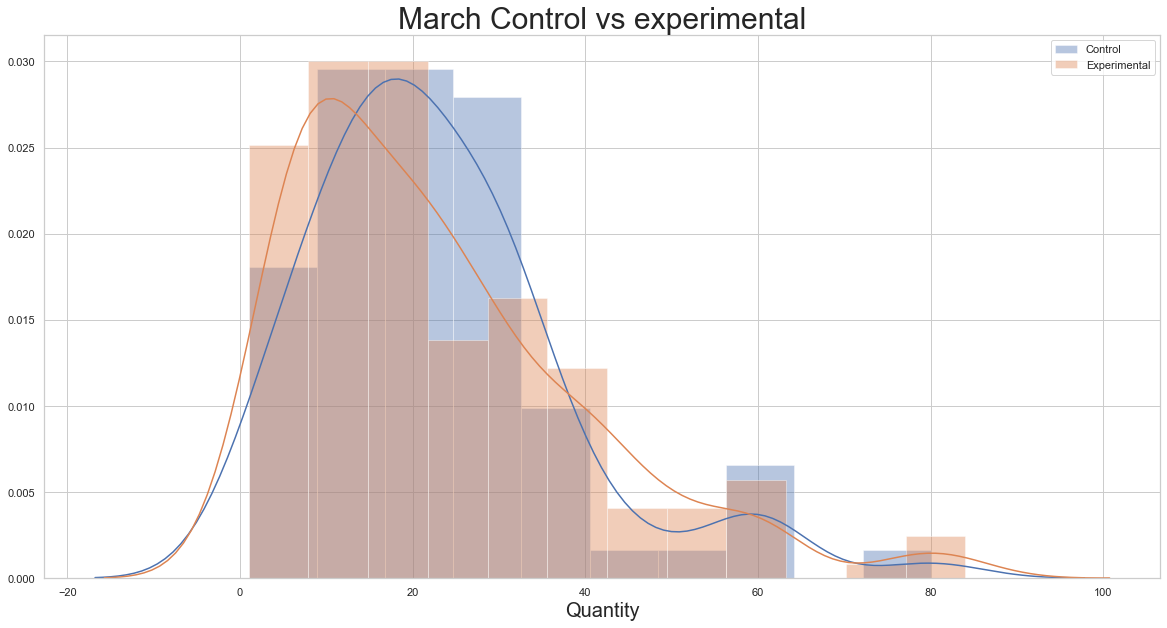

In [605]:
ctrl_q2_mar = Order_date_ctrl_mar_df['2013-1q']
exp_q2_mar = Order_date_exp_mar_df['2014-1q']
plt.figure(figsize=(20, 10))
sns.distplot(ctrl_q2_mar, label='Control')
sns.distplot(exp_q2_mar, label='Experimental' )
plt.title('March Control vs experimental',fontsize=30)
plt.xlabel('Quantity', fontsize=20)
plt.legend();

In [606]:
scipy.stats.normaltest(ctrl_q2_mar)

NormaltestResult(statistic=24.08651862290501, pvalue=5.88408498777161e-06)

In [607]:
scipy.stats.normaltest(exp_q2_mar)

NormaltestResult(statistic=39.61856086585556, pvalue=2.4942433184298923e-09)

In [608]:
control_sample_mar_q2 = create_sample_distribution(ctrl_q2_mar)
experiment_sample_mar_q2 = create_sample_distribution(exp_q2_mar)

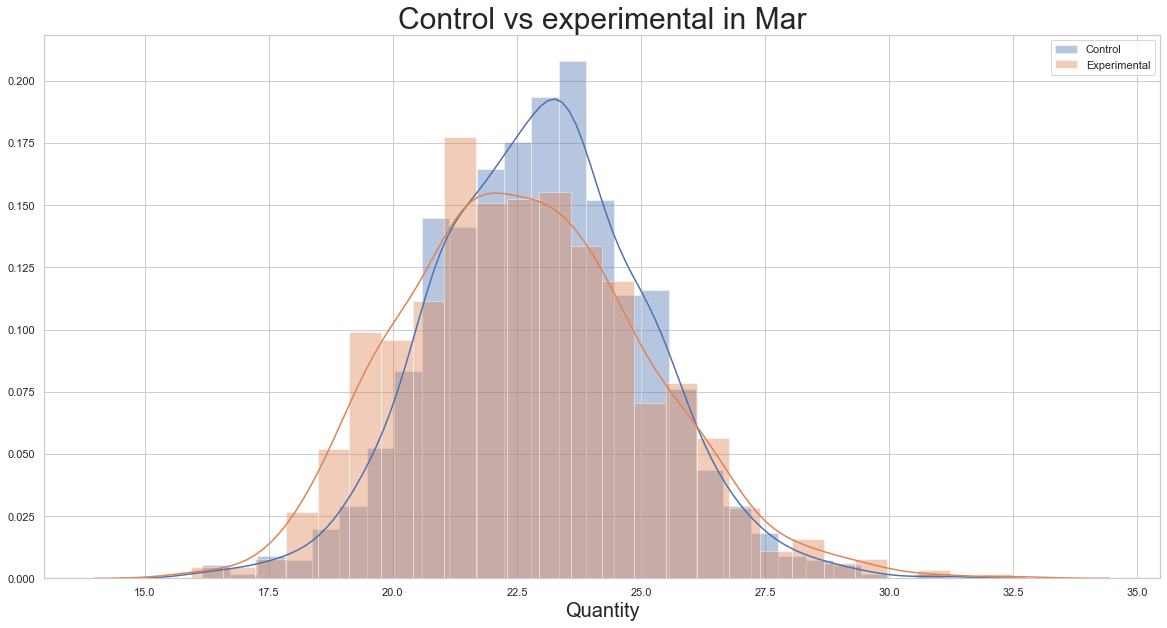

In [609]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample_mar_q2, label='Control')
sns.set_color_codes("muted")
sns.distplot(experiment_sample_mar_q2, label='Experimental' )
plt.title('Control vs experimental in Mar',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

In [610]:
p = stats.ttest_ind(control_sample_mar_q2, experiment_sample_mar_q2)[1]
d = Cohen_d(np.array(control_sample_mar_q2), np.array(experiment_sample_mar_q2))

In [611]:
 print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 0.0014485785066543789 effect size is 0.14269845064723893
It has a small effect
Reject Null Hypothesis


## Apr

In [612]:
cur.execute("""Select OrderDate,
                      Quantity as '2013-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2013-04-01' And
                     OrderDate < '2013-05-01'
               ;""")
Order_date_ctrl_apr_df = pd.DataFrame(cur.fetchall())
Order_date_ctrl_apr_df.columns = [x[0] for x in cur.description]

In [626]:
Order_date_ctrl_apr_df['2013-1q'].mean()

23.604938271604937

In [613]:
cur.execute("""Select OrderDate,
                      Quantity as '2014-1q'
               From OrderDetail od
               Join [Order] o
               On od.OrderId = o.Id
               Where OrderDate >= '2014-04-01' And
                     OrderDate < '2014-05-01'
               ;""")
Order_date_exp_apr_df = pd.DataFrame(cur.fetchall())
Order_date_exp_apr_df.columns = [x[0] for x in cur.description]

In [628]:
Order_date_exp_apr_df['2014-1q'].mean()

26.0

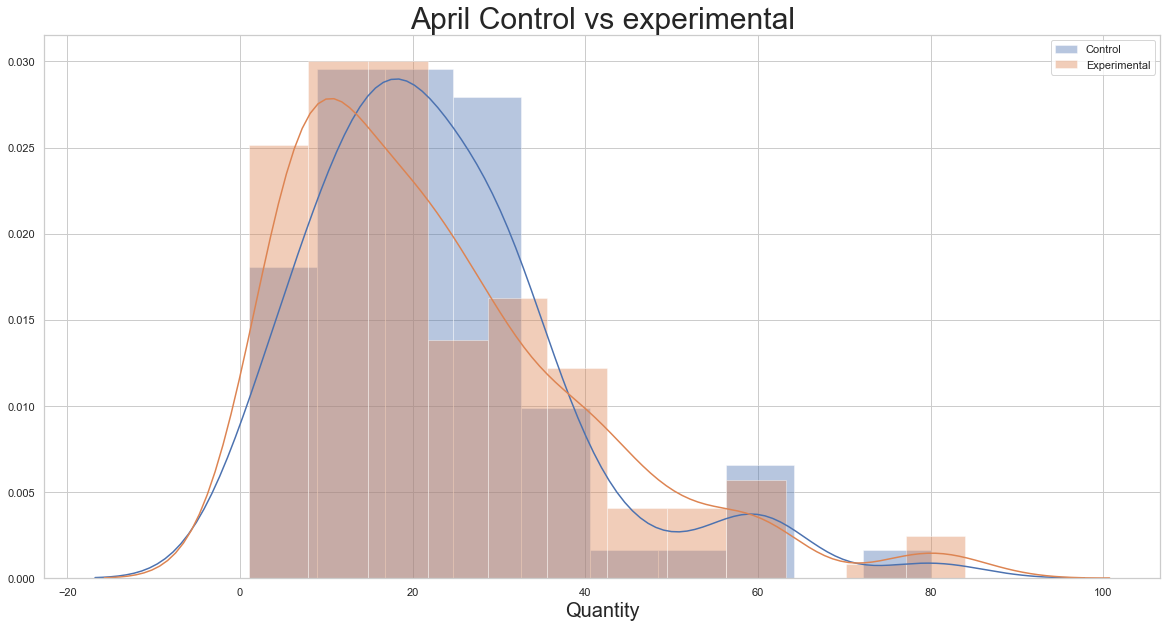

In [614]:
ctrl_q2_apr = Order_date_ctrl_apr_df['2013-1q']
exp_q2_apr = Order_date_exp_apr_df['2014-1q']
plt.figure(figsize=(20, 10))
sns.distplot(ctrl_q2_mar, label='Control')
sns.distplot(exp_q2_mar, label='Experimental' )
plt.title('April Control vs experimental',fontsize=30)
plt.xlabel('Quantity', fontsize=20)
plt.legend();

In [615]:
scipy.stats.normaltest(ctrl_q2_apr)

NormaltestResult(statistic=47.38722468371864, pvalue=5.1285536562367567e-11)

In [616]:
scipy.stats.normaltest(exp_q2_apr)

NormaltestResult(statistic=59.15293619176865, pvalue=1.4292332519698628e-13)

In [617]:
control_sample_apr_q2 = create_sample_distribution(ctrl_q2_apr)
experiment_sample_apr_q2 = create_sample_distribution(exp_q2_apr)

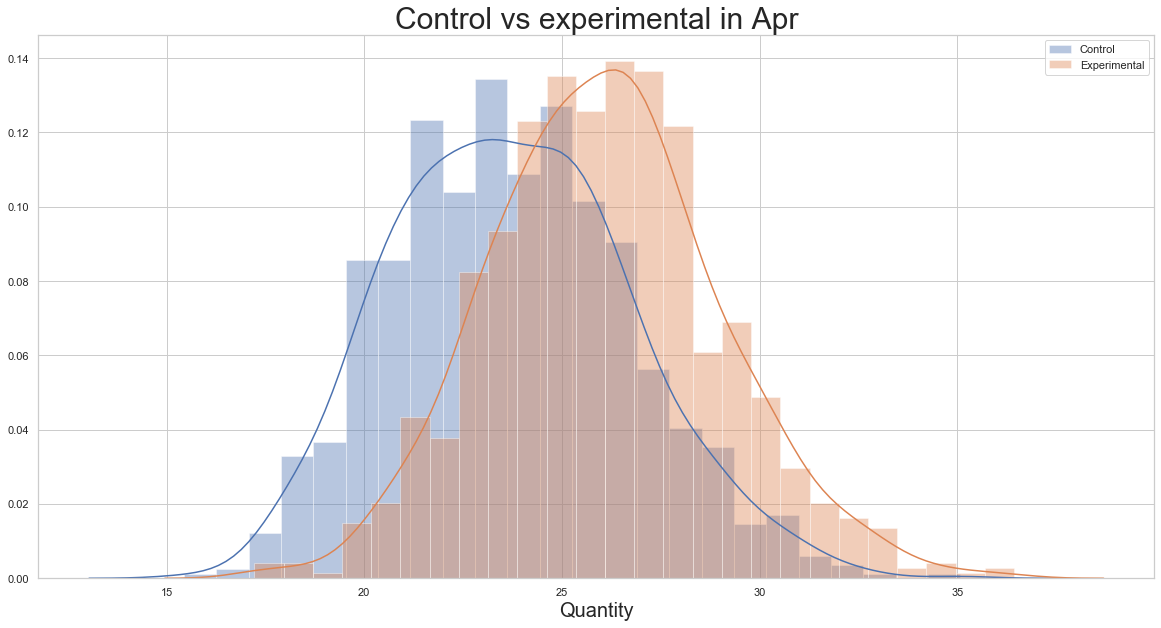

In [618]:
plt.figure(figsize=(20, 10))
sns.distplot(control_sample_apr_q2, label='Control')
sns.set_color_codes("muted")
sns.distplot(experiment_sample_apr_q2, label='Experimental' )
plt.title('Control vs experimental in Apr',fontsize=30)
plt.xlabel('Quantity',fontsize=20)
plt.legend();

In [619]:
p = stats.ttest_ind(control_sample_apr_q2, experiment_sample_apr_q2)[1]
d = Cohen_d(np.array(control_sample_apr_q2), np.array(experiment_sample_apr_q2))

In [620]:
print('p value is', p,'effect size is',d)
if d >= 0.8:
    print('It has a large effect') 
elif (d>=0.5)&(d<0.8): 
    print('It has a medium effect') 
else: 
    print('It has a small effect')

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 7.753261821219675e-66 effect size is 0.7959772743981179
It has a medium effect
Reject Null Hypothesis


## Summary

In general we can see a sales quantity decline for the first quarter of 2014. In particular, Janurary has contributed most of the recession of sales and followed by Feb and Mar. April is the only month we see an sales quantity improvement compared with last year. 

## Q3: Does freight same across different shipping companies?

H0: freight is same across different shipping companies

H1: freight is not same across different shipping companies

In [629]:
Order_df

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico
826,11074,SIMOB,7,2014-05-06,2014-06-03,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark
827,11075,RICSU,8,2014-05-06,2014-06-03,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
828,11076,BONAP,4,2014-05-06,2014-06-03,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,Western Europe,13008,France


In [630]:
cur.execute("""Select * 
               From Shipper
;""")
Shipper_df = pd.DataFrame(cur.fetchall())
Shipper_df.columns = [x[0] for x in cur.description]

In [631]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [635]:
cur.execute("""Select o.Id, 
                      o.Shipvia, 
                      o.Freight, 
                      s.CompanyName
               From [Order] o
               Join Shipper s
               On s.Id = o.Shipvia
               Group by 1
               
;""")
Freight_df = pd.DataFrame(cur.fetchall())
Freight_df.columns = [x[0] for x in cur.description]

In [636]:
Freight_df

,Id,ShipVia,Freight,CompanyName
0,10248,3,32.38,Federal Shipping
1,10249,1,11.61,Speedy Express
2,10250,2,65.83,United Package
3,10251,1,41.34,Speedy Express
4,10252,2,51.30,United Package
...,...,...,...,...
825,11073,2,24.95,United Package
826,11074,2,18.44,United Package
827,11075,2,6.19,United Package
828,11076,2,38.28,United Package


because we have three shipping companies, therefore we will use an ANOVA table to analyse the results

In [644]:
Freight_3_df = Freight_df[Freight_df['ShipVia']==3]
Freight_2_df = Freight_df[Freight_df['ShipVia']==2]
Freight_1_df = Freight_df[Freight_df['ShipVia']==1]

In [645]:
Freight_3_df
Freight_2_df
Freight_1_df

,Id,ShipVia,Freight,CompanyName
1,10249,1,11.61,Speedy Express
3,10251,1,41.34,Speedy Express
10,10258,1,140.51,Speedy Express
12,10260,1,55.09,Speedy Express
17,10265,1,55.28,Speedy Express
...,...,...,...,...
806,11054,1,0.33,Speedy Express
816,11064,1,30.09,Speedy Express
817,11065,1,12.91,Speedy Express
822,11070,1,136.00,Speedy Express


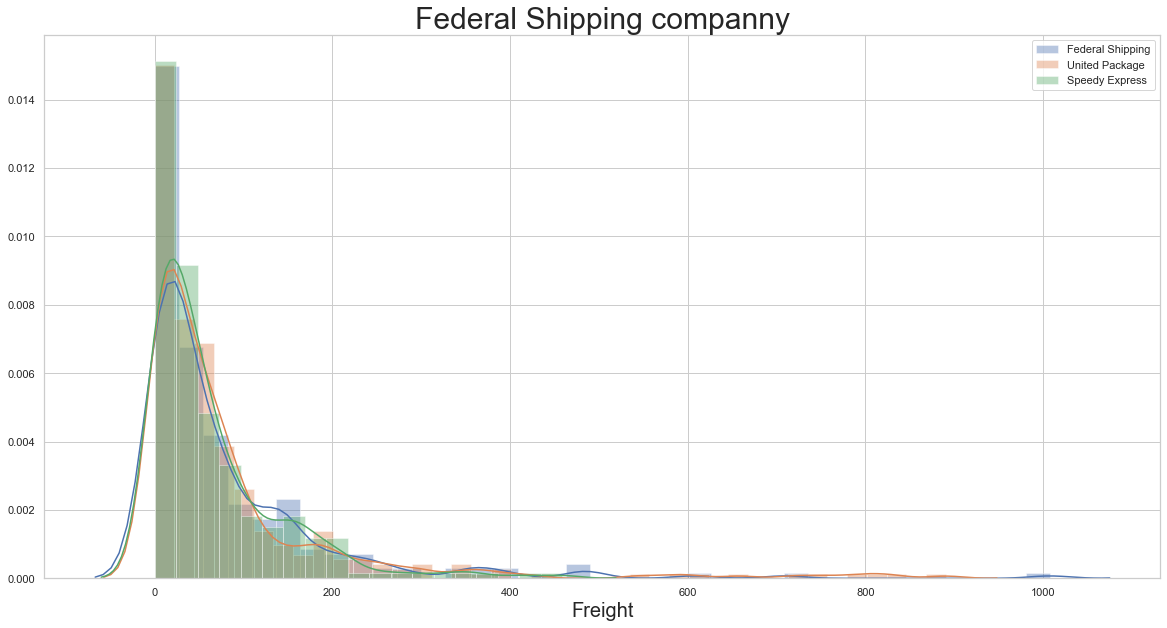

In [646]:
Freight_3 = Freight_3_df['Freight']
Freight_2 = Freight_2_df['Freight']
Freight_1 = Freight_1_df['Freight']

plt.figure(figsize=(20, 10))
sns.distplot(Freight_3, label='Federal Shipping')
sns.distplot(Freight_2, label='United Package')
sns.distplot(Freight_1, label='Speedy Express')

plt.title('Federal Shipping companny',fontsize=30)
plt.xlabel('Freight', fontsize=20)
plt.legend();

## Normalize the data

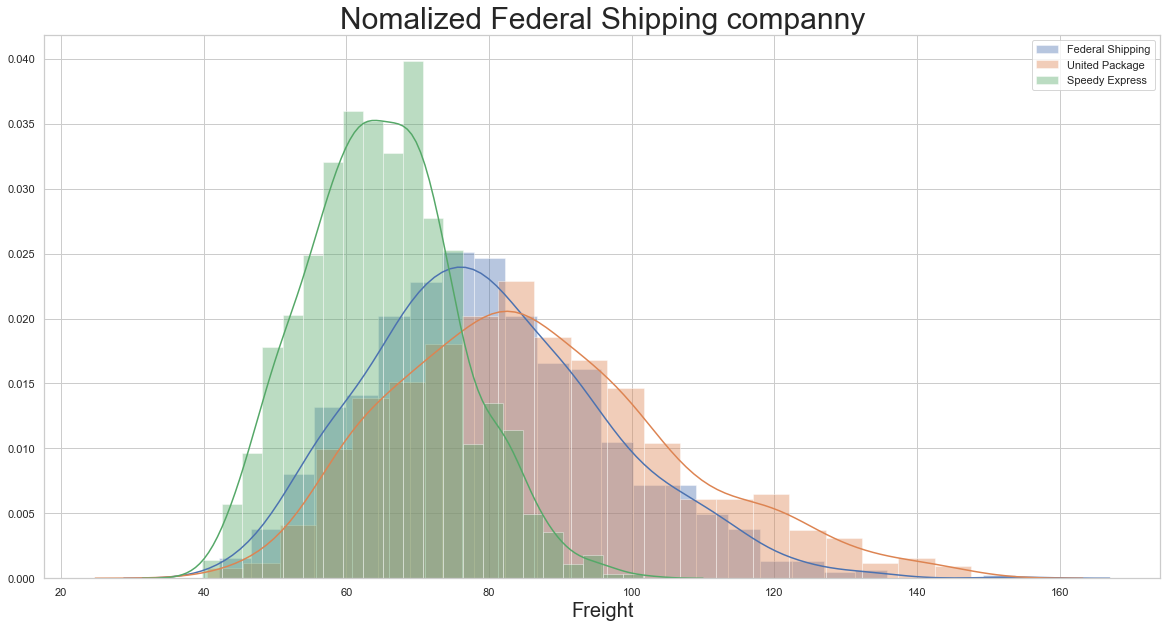

In [648]:
freight_3_sample = create_sample_distribution(Freight_3)
freight_2_sample = create_sample_distribution(Freight_2)
freight_1_sample = create_sample_distribution(Freight_1)

plt.figure(figsize=(20, 10))
sns.distplot(freight_3_sample, label='Federal Shipping')
sns.distplot(freight_2_sample, label='United Package')
sns.distplot(freight_1_sample, label='Speedy Express')
plt.title('Nomalized Federal Shipping companny',fontsize=30)
plt.xlabel('Freight', fontsize=20)
plt.legend();

In [657]:
freight_list = [freight_3_sample,freight_2_sample, freight_1_sample]
combos_freight = combinations(freight_list, 2)

for combo in list(combos_freight):
    freight1 = combo[0]
    freight2 = combo[1]
    p = stats.ttest_ind(freight1, freight2, equal_var=False)[1]
    d = Cohen_d(np.array(freight1), np.array(freight2))
    print('p value is', p)
    print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')

p value is 1.2103294832648631e-15
Reject Null Hypothesis
p value is 1.6717919416429221e-106
Reject Null Hypothesis
p value is 1.6963083947005558e-159
Reject Null Hypothesis
